# CAFA 5 Competition : Protein Function Prediction

# TODO
- probar en Multi poner la length de la secuencia y su representcion num de la especie (no hacer onehot)
- incluir la validacion que usan en una discusion para esta competi
- pooling metodos https://www.kaggle.com/code/daehunbae/esm-2-3b-embeddings-with-three-pooling-methods/notebook

In [1]:
import pandas as pd
sub = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv", sep= "\t", header = None)
sub.columns = ["The Protein ID", "The Gene Ontology term (GO) ID", "Predicted link probability that GO appear in Protein"]
sub.head(5)

,The Protein ID,The Gene Ontology term (GO) ID,Predicted link probability that GO appear in Protein
0,A0A0A0MRZ7,GO:0000001,0.123
1,A0A0A0MRZ7,GO:0000002,0.123
2,A0A0A0MRZ8,GO:0000001,0.123
3,A0A0A0MRZ8,GO:0000002,0.123
4,A0A0A0MRZ9,GO:0000001,0.123


The evaluation metric used in this competition is the weighted F-measure, which combines precision and recall, taking into account the hierarchical structure of the Gene Ontology (GO). The formula for calculating the weighted F-measure is as follows:

$Weighted \ F-measure = \frac{(1 + β^2) * (weighted \ precision * weighted recall)}{((β^2 * weighted \ precision) + weighted \ recall)}$

where:
- β is a parameter that controls the trade-off between precision and recall. In this competition, β is set to 1, resulting in an equal weighting of precision and recall.
- Weighted precision is the precision score, considering the weights of the predicted terms. It is calculated as the sum of the products of the predicted term's weight and its true positive count, divided by the sum of the weights of all predicted terms.
- Weighted recall is the recall score, considering the weights of the true positive terms. It is calculated as the sum of the products of the true positive term's weight and its count, divided by the sum of the weights of all true positive terms.

Note: The specific formulas for weighted precision and weighted recall are provided in the competition materials and utilize additional information such as term weights and true positive counts.

# General Baseline in this Notebook

- **1 - Collect Embedding vectors from pre-trained protein function prediction models (T5, ProtBERT or EMS2) :**

Sources for embeddings vectors : 
- *T5* : https://www.kaggle.com/datasets/sergeifironov/t5embeds

- *ProtBERT* : https://www.kaggle.com/datasets/henriupton/protbert-embeddings-for-cafa5

- *EMS2* : https://www.kaggle.com/datasets/viktorfairuschin/cafa-5-ems-2-embeddings-numpy

- **2 - Generate labels from train_terms file** : by considering the top K most common GO terms in all Proteins set, generate for each protein a sparse vector of length K to indicate the true probabilities that each of the K GO terms are in the Protein (0 or 1). Here we retain K = 600

- **3 - Create Pytorch Dataset class that can handle Protein ID and embeddings**.

- **4 - Create Pytorch Model class for prediction** : can be any architecture of Multilabel classification model that can turn embeddings of shape (E,) to probabilities of shape (K,). Here we explore **MultiLayerPerceptron** and **ConvNN1d** Networks.

- **5 - Make Cross Validation w.r.t the F-1 measure and do Hyperparameter tuning thanks to Weights and Biases package (Wandb)**

![baseline-image](https://www.researchgate.net/publication/334642149/figure/fig1/AS:783995214249986@1563930433525/Flow-chart-of-STRING2GO-based-protein-function-prediction-method.png)

## **Flow-chart of STRING2GO-based protein function prediction method**

# 1. Imports / Config

In [2]:
MAIN_DIR = "/kaggle/input/cafa-5-protein-function-prediction"
seed = 54

# UTILITARIES
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import gc
import multiprocessing as mp
import copy
import logging
from joblib import dump
import pickle


# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy
from torch.utils.data import Subset
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import random
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# WANDB FOR LIGHTNING :
import wandb

# FILES VISUALIZATION
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/cafa5-labels-2500/train_targets_top3000.npy
/kaggle/input/cafa5-labels-2500/train_targets.pkl
/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_ids.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_embeddings.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_ids.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_embeddings.npy
/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy
/kaggle/input/protbert-embeddings-for-cafa5/train_embeddings.npy
/kaggle/input/protbert-embeddings-for-cafa5/test_ids.npy
/kaggle/input/protbert-embeddings-for-cafa5/test_embeddings.npy
/kaggle/input/t5embeds/train_ids.npy
/kaggle/input/t5embeds/test_embeds.npy
/kaggle/input/t5embeds/train_embeds.npy
/kaggle/input/t5embeds/test_ids.npy
/kaggle/input/4637427/test_ids_esm2_t36_3B_UR50D.npy
/kaggle/input/4637427/train_ids_esm2_t36_3B_UR50D.npy
/kaggle/input/4637427/test_embeds_esm2_t36_3B_UR50D.npy
/kaggle/input/4637427/train_embeds_esm2_t36_3B_UR50D.npy
/kaggle/input/cafa5-pytorch-labe

In [3]:
class config:
    train_sequences_path = MAIN_DIR  + "/Train/train_sequences.fasta"
    train_labels_path = MAIN_DIR + "/Train/train_terms.tsv"
    test_sequences_path = MAIN_DIR + "/Test (Targets)/testsuperset.fasta"
    
    num_labels = 3000 # 1499
    n_epochs = 15
    batch_size = 128 # 128
    lr = 0.001 # 0.001
    model_type = 'linear' # convolutional, lstm, multi, attention, linear
    apply_PCA = True
    PCA_components = 1500
    pca = PCA(n_components=PCA_components)
    embedding_a_usar = "EMS2_t36" #EMS2_t36
    set_seed = True # para comparar modelos con una seed fija en el train_split
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(config.device)

cpu


# Metricas https://www.kaggle.com/code/sergeifironov/validate-ridge/notebook

In [5]:
class Graph:
    """
    Ontology class. One ontology == one namespace
    DAG is the adjacence matrix (sparse) which represent a Directed Acyclic Graph where
    DAG(i,j) == 1 means that the go term i is_a (or is part_of) j
    Parents that are in a different namespace are discarded
    """
    def __init__(self, namespace, terms_dict, ia_dict=None, orphans=False):
        """
        terms_dict = {term: {name: , namespace: , def: , alt_id: , rel:}}
        """
        self.namespace = namespace
        self.dag = []  # [[], ...] terms (rows, axis 0) x parents (columns, axis 1)
        self.terms_dict = {}  # {term: {index: , name: , namespace: , def: }  used to assign term indexes in the gt
        self.terms_list = []  # [{id: term, name:, namespace: , def:, adg: [], children: []}, ...]
        self.idxs = None  # Number of terms
        self.order = None
        self.toi = None
        self.ia = None

        rel_list = []
        for self.idxs, (term_id, term) in enumerate(terms_dict.items()):
            rel_list.extend([[term_id, rel, term['namespace']] for rel in term['rel']])
            self.terms_list.append({'id': term_id, 'name': term['name'], 'namespace': namespace, 'def': term['def'],
                                 'adj': [], 'children': []})
            self.terms_dict[term_id] = {'index': self.idxs, 'name': term['name'], 'namespace': namespace, 'def': term['def']}
            for a_id in term['alt_id']:
                self.terms_dict[a_id] = copy.copy(self.terms_dict[term_id])
        self.idxs += 1

        self.dag = np.zeros((self.idxs, self.idxs), dtype='bool')

        # id1 term (row, axis 0), id2 parent (column, axis 1)
        for id1, id2, ns in rel_list:
            if self.terms_dict.get(id2):
                i = self.terms_dict[id1]['index']
                j = self.terms_dict[id2]['index']
                self.dag[i, j] = 1
                self.terms_list[i]['adj'].append(j)
                self.terms_list[j]['children'].append(i)
                logging.debug("i,j {},{} {},{}".format(i, j, id1, id2))
            else:
                logging.debug('Skipping branch to external namespace: {}'.format(id2))
        logging.debug("dag {}".format(self.dag))
        # Topological sorting
        self.top_sort()
        logging.debug("order sorted {}".format(self.order))

        if orphans:
            self.toi = np.arange(self.dag.shape[0])  # All terms, also those without parents
        else:
            self.toi = np.nonzero(self.dag.sum(axis=1) > 0)[0]  # Only terms with parents
        logging.debug("toi {}".format(self.toi))

        if ia_dict is not None:
            self.set_ia(ia_dict)

        return

    def top_sort(self):
        """
        Takes a sparse matrix representing a DAG and returns an array with nodes indexes in topological order
        https://en.wikipedia.org/wiki/Topological_sorting
        """
        indexes = []
        visited = 0
        (rows, cols) = self.dag.shape

        # create a vector containing the in-degree of each node
        in_degree = self.dag.sum(axis=0)
        # logging.debug("degree {}".format(in_degree))

        # find the nodes with in-degree 0 (leaves) and add them to the queue
        queue = np.nonzero(in_degree == 0)[0].tolist()
        # logging.debug("queue {}".format(queue))

        # for each element of the queue increment visits, add them to the list of ordered nodes
        # and decrease the in-degree of the neighbor nodes
        # and add them to the queue if they reach in-degree == 0
        while queue:
            visited += 1
            idx = queue.pop(0)
            indexes.append(idx)
            in_degree[idx] -= 1
            l = self.terms_list[idx]['adj']
            if len(l) > 0:
                for j in l:
                    in_degree[j] -= 1
                    if in_degree[j] == 0:
                        queue.append(j)

        # if visited is equal to the number of nodes in the graph then the sorting is complete
        # otherwise the graph can't be sorted with topological order
        if visited == rows:
            self.order = indexes
        else:
            raise Exception("The sparse matrix doesn't represent an acyclic graph")

    def set_ia(self, ia_dict):
        self.ia = np.zeros(self.idxs, dtype='float')
        for term_id in self.terms_dict:
            if ia_dict.get(term_id):
                self.ia[self.terms_dict[term_id]['index']] = ia_dict.get(term_id)
            else:
                logging.debug('Missing IA for term: {}'.format(term_id))
        # Convert inf to zero
        np.nan_to_num(self.ia, copy=False, nan=0, posinf=0, neginf=0)
        self.toi = np.nonzero(self.ia > 0)[0]


class Prediction:
    """
    The score matrix contains the scores given by the predictor for every node of the ontology
    """
    def __init__(self, ids, matrix, idx, namespace=None):
        self.ids = ids
        self.matrix = matrix  # scores
        self.next_idx = idx
        # self.n_pred_seq = idx + 1
        self.namespace = namespace

    def __str__(self):
        return "\n".join(["{}\t{}\t{}".format(index, self.matrix[index], self.namespace) for index, _id in enumerate(self.ids)])


class GroundTruth:
    def __init__(self, ids, matrix, namespace=None):
        self.ids = ids
        self.matrix = matrix
        self.namespace = namespace


def propagate(matrix, ont, order, mode='max'):
    """
    Update inplace the score matrix (proteins x terms) up to the root taking the max between children and parents
    """
    if matrix.shape[0] == 0:
        raise Exception("Empty matrix")

    deepest = np.where(np.sum(matrix[:, order], axis=0) > 0)[0][0]
    if deepest.size == 0:
        raise Exception("The matrix is empty")

    # Remove leaves
    order_ = np.delete(order, [range(0, deepest)])

    for i in order_:
        # Get direct children
        children = np.where(ont.dag[:, i] != 0)[0]
        if children.size > 0:
            cols = np.concatenate((children, [i]))
            if mode == 'max':
                matrix[:, i] = matrix[:, cols].max(axis=1)
            elif mode == 'fill':
                rows = np.where(matrix[:, i] == 0)[0]
                if rows.size:
                    idx = np.ix_(rows, cols)
                    matrix[rows, i] = matrix[idx].max(axis=1)
    return


def obo_parser(obo_file, valid_rel=("is_a", "part_of")):
    """
    Parse a OBO file and returns a list of ontologies, one for each namespace.
    Obsolete terms are excluded as well as external namespaces.
    """
    term_dict = {}
    term_id = None
    namespace = None
    name = None
    term_def = None
    alt_id = []
    rel = []
    obsolete = True
    with open(obo_file) as f:
        for line in f:
            line = line.strip().split(": ")
            if line and len(line) > 1:
                k = line[0]
                v = ": ".join(line[1:])
                if k == "id":
                    # Populate the dictionary with the previous entry
                    if term_id is not None and obsolete is False and namespace is not None:
                        term_dict.setdefault(namespace, {})[term_id] = {'name': name,
                                                                       'namespace': namespace,
                                                                       'def': term_def,
                                                                       'alt_id': alt_id,
                                                                       'rel': rel}
                    # Assign current term ID
                    term_id = v

                    # Reset optional fields
                    alt_id = []
                    rel = []
                    obsolete = False
                    namespace = None

                elif k == "alt_id":
                    alt_id.append(v)
                elif k == "name":
                    name = v
                elif k == "namespace" and v != 'external':
                    namespace = v
                elif k == "def":
                    term_def = v
                elif k == 'is_obsolete':
                    obsolete = True
                elif k == "is_a" and k in valid_rel:
                    s = v.split('!')[0].strip()
                    rel.append(s)
                elif k == "relationship" and v.startswith("part_of") and "part_of" in valid_rel:
                    s = v.split()[1].strip()
                    rel.append(s)

        # Last record
        if obsolete is False and namespace is not None:
            term_dict.setdefault(namespace, {})[term_id] = {'name': name,
                                                          'namespace': namespace,
                                                          'def': term_def,
                                                          'alt_id': alt_id,
                                                          'rel': rel}
    return term_dict


def gt_parser(gt_file, ontologies):
    """
    Parse ground truth file. Discard terms not included in the ontology.
    """
    gt_dict = {}
    with open(gt_file) as f:
        for line in f:
            line = line.strip().split()
            if line:
                p_id, term_id = line[:2]
                for ont in ontologies:
                    if term_id in ont.terms_dict:
                        gt_dict.setdefault(ont.namespace, {}).setdefault(p_id, []).append(term_id)
                        break

    gts = {}
    for ont in ontologies:
        if gt_dict.get(ont.namespace):
            matrix = np.zeros((len(gt_dict[ont.namespace]), ont.idxs), dtype='bool')
            ids = {}
            for i, p_id in enumerate(gt_dict[ont.namespace]):
                ids[p_id] = i
                for term_id in gt_dict[ont.namespace][p_id]:
                    matrix[i, ont.terms_dict[term_id]['index']] = 1
            propagate(matrix, ont, ont.order, mode='max')
            gts[ont.namespace] = GroundTruth(ids, matrix, ont.namespace)

    return gts


def pred_parser(f, ontologies, gts, prop_mode, max_terms=None):
    """
    Parse a prediction file and returns a list of prediction objects, one for each namespace.
    If a predicted is predicted multiple times for the same target, it stores the max.
    This is the slow step if the input file is huge, ca. 1 minute for 5GB input on SSD disk.
    """
    ids = {}
    matrix = {}
    ns_dict = {}  # {namespace: term}
    onts = {ont.namespace: ont for ont in ontologies}
    for ns in gts:
        matrix[ns] = np.zeros(gts[ns].matrix.shape, dtype='float')
        ids[ns] = {}
        for term in onts[ns].terms_dict:
            ns_dict[term] = ns

    for line in f:
        p_id, term_id, prob = line
        ns = ns_dict.get(term_id)
        if ns in gts and p_id in gts[ns].ids:
            i = gts[ns].ids[p_id]
            if max_terms is None or np.count_nonzero(matrix[ns][i]) <= max_terms:
                j = onts[ns].terms_dict.get(term_id)['index']
                ids[ns][p_id] = i
                matrix[ns][i, j] = max(matrix[ns][i, j], float(prob))

    predictions = []
    for ns in ids:
        if ids[ns]:
            propagate(matrix[ns], onts[ns], onts[ns].order, mode=prop_mode)
            predictions.append(Prediction(ids[ns], matrix[ns], len(ids[ns]), ns))

    if not predictions:
        raise Exception("Empty prediction, check format")

    return predictions


def ia_parser(file):
    ia_dict = {}
    with open(file) as f:
        for line in f:
            if line:
                term, ia = line.strip().split()
                ia_dict[term] = float(ia)
    return ia_dict

# Computes the root terms in the dag
def get_roots_idx(dag):
    return np.where(dag.sum(axis=1) == 0)[0]


# Computes the leaf terms in the dag
def get_leafs_idx(dag):
    return np.where(dag.sum(axis=0) == 0)[0]


# Return a mask for all the predictions (matrix) >= tau
def solidify_prediction(pred, tau):
    return pred >= tau


# computes the f metric for each precision and recall in the input arrays
def compute_f(pr, rc):
    n = 2 * pr * rc
    d = pr + rc
    return np.divide(n, d, out=np.zeros_like(n, dtype=float), where=d != 0)


def compute_s(ru, mi):
    return np.sqrt(ru**2 + mi**2)
    # return np.where(np.isnan(ru), mi, np.sqrt(ru + np.nan_to_num(mi)))


def compute_metrics_(tau_arr, g, pred, toi, n_gt, wn_gt=None, ic_arr=None):

    metrics = np.zeros((len(tau_arr), 7), dtype='float')  # cov, pr, rc, wpr, wrc, ru, mi

    for i, tau in enumerate(tau_arr):

        p = solidify_prediction(pred.matrix[:, toi], tau)

        # number of proteins with at least one term predicted with score >= tau
        metrics[i, 0] = (p.sum(axis=1) > 0).sum()

        # Terms subsets
        intersection = np.logical_and(p, g)  # TP

        # Subsets size
        n_pred = p.sum(axis=1)
        n_intersection = intersection.sum(axis=1)

        # Precision, recall
        metrics[i, 1] = np.divide(n_intersection, n_pred, out=np.zeros_like(n_intersection, dtype='float'),
                                  where=n_pred > 0).sum()
        metrics[i, 2] = np.divide(n_intersection, n_gt, out=np.zeros_like(n_gt, dtype='float'), where=n_gt > 0).sum()

        if ic_arr is not None:
            # Terms subsets
            remaining = np.logical_and(np.logical_not(p), g)  # FN --> not predicted but in the ground truth
            mis = np.logical_and(p, np.logical_not(g))  # FP --> predicted but not in the ground truth

            # Weighted precision, recall
            wn_pred = (p * ic_arr[toi]).sum(axis=1)
            wn_intersection = (intersection * ic_arr[toi]).sum(axis=1)

            metrics[i, 3] = np.divide(wn_intersection, wn_pred, out=np.zeros_like(n_intersection, dtype='float'),
                                      where=n_pred > 0).sum()
            metrics[i, 4] = np.divide(wn_intersection, wn_gt, out=np.zeros_like(n_intersection, dtype='float'),
                                      where=n_gt > 0).sum()

            # Misinformation, remaining uncertainty
            metrics[i, 5] = (remaining * ic_arr[toi]).sum(axis=1).sum()
            metrics[i, 6] = (mis * ic_arr[toi]).sum(axis=1).sum()
    return metrics


def compute_metrics(pred, gt, toi, tau_arr, ic_arr=None, n_cpu=0):
    """
    Takes the prediction and the ground truth and for each threshold in tau_arr
    calculates the confusion matrix and returns the coverage,
    precision, recall, remaining uncertainty and misinformation.
    Toi is the list of terms (indexes) to be considered
    """
    g = gt.matrix[:, toi]
    n_gt = g.sum(axis=1)
    wn_gt = None
    if ic_arr is not None:
        wn_gt = (g * ic_arr[toi]).sum(axis=1)

    # Parallelization
    if n_cpu == 0:
        n_cpu = mp.cpu_count()

    arg_lists = [[tau_arr, g, pred, toi, n_gt, wn_gt, ic_arr] for tau_arr in np.array_split(tau_arr, n_cpu)]
    if 0:
        # Original parallel way (# It does not work on Kaggle)
        arg_lists = [[tau_arr, g, pred, toi, n_gt, wn_gt, ic_arr] for tau_arr in np.array_split(tau_arr, n_cpu)]
        with mp.Pool(processes=n_cpu) as pool:
            metrics = np.concatenate(pool.starmap(compute_metrics_, arg_lists), axis=0)
    else: 
        # no-parallel: 
        metrics = compute_metrics_(tau_arr, g, pred, toi, n_gt, wn_gt, ic_arr )

    return pd.DataFrame(metrics, columns=["cov", "pr", "rc", "wpr", "wrc", "ru", "mi"])


def evaluate_prediction(prediction, gt, ontologies, tau_arr, normalization='cafa', n_cpu=0):
    dfs = []
    for p in prediction:
        ns = p.namespace
        ne = np.full(len(tau_arr), gt[ns].matrix.shape[0])

        ont = [o for o in ontologies if o.namespace == ns][0]

        # cov, pr, rc, wpr, wrc, ru, mi
        metrics = compute_metrics(p, gt[ns], ont.toi, tau_arr, ont.ia, n_cpu)

        for column in ["pr", "rc", "wpr", "wrc", "ru", "mi"]:
            if normalization == 'gt' or (column in ["rc", "wrc"] and normalization == 'cafa'):
                metrics[column] = np.divide(metrics[column], ne, out=np.zeros_like(metrics[column], dtype='float'), where=ne > 0)
            else:
                metrics[column] = np.divide(metrics[column], metrics["cov"], out=np.zeros_like(metrics[column], dtype='float'), where=metrics["cov"] > 0)

        metrics['ns'] = [ns] * len(tau_arr)
        metrics['tau'] = tau_arr
        metrics['cov'] = np.divide(metrics['cov'], ne, out=np.zeros_like(metrics['cov'], dtype='float'), where=ne > 0)
        metrics['f'] = compute_f(metrics['pr'], metrics['rc'])
        metrics['wf'] = compute_f(metrics['wpr'], metrics['wrc'])
        metrics['s'] = compute_s(metrics['ru'], metrics['mi'])

        dfs.append(metrics)

    return pd.concat(dfs)

# 2. Baseline

- Use ProtBERT/T5 embedding vectors for each Sequence ID and its associated Protein Sequence. 

- Define a Pytorch Dataset to load all ids/sequences of the train+test sets and their respective ProtBert embeddings

- Define Pytorch Model architecture in order to use these embeddings to proceed classification task : to each ID we associate a probability to be associated to each GO term **For this part, just consider the top_n most common GO terms as labels**

- Return desired probabilities for test set

# 4. Collect labels vectors for train/test

In [6]:
# print("GENERATE TARGETS FOR ENTRY IDS ("+str(config.num_labels)+" MOST COMMON GO TERMS)")
# ids = np.load("/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy")
# labels = pd.read_csv(config.train_labels_path, sep = "\t")

# top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
# labels_names = top_terms[:config.num_labels].index.values
# train_labels_sub = labels[(labels.term.isin(labels_names)) & (labels.EntryID.isin(ids))]
# id_labels = train_labels_sub.groupby('EntryID')['term'].apply(list).to_dict()


# go_terms_map = {label: i for i, label in enumerate(labels_names)}
# labels_matrix = np.empty((len(ids), len(labels_names)))

# for index, id in tqdm(enumerate(ids)):
#     id_gos_list = id_labels[id]
#     temp = [go_terms_map[go] for go in labels_names if go in id_gos_list]
#     labels_matrix[index, temp] = 1

# np.save("/kaggle/working/train_targets_top"+str(config.num_labels)+".npy", np.array(labels_matrix))
# print("GENERATION FINISHED!")
# labels_list = []
# for l in range(labels_matrix.shape[0]):
#     labels_list.append(labels_matrix[l, :])

# labels_df = pd.DataFrame(data={"EntryID":ids, "labels_vect":labels_list})
# labels_df.to_pickle("/kaggle/working/"+'train'+"_targets.pkl")
# print("GENERATION FINISHED!")

# 5. Pytorch Dataset Architecture

In [7]:
# Directories for the different embedding vectors : 
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "EMS2" : "cafa-5-ems-2-embeddings-numpy",
    "EMS2_t36": "4637427"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "EMS2" : 1280,
    "EMS2_t36": 2560
}

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
class ProteinSequenceDataset(Dataset):
    
    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        if embeddings_source in ["ProtBERT", "EMS2"]:
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
        
        if embeddings_source == "T5":
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
            
        if embeddings_source == "EMS2_t36":
            embeds = np.load("/kaggle/input/4637427/" + datatype + "_embeds_esm2_t36_3B_UR50D.npy")
            ids = np.load("/kaggle/input/4637427/" + datatype + "_ids_esm2_t36_3B_UR50D.npy")
            
            
        # reduce memory
        embeds = reduce_mem_usage(pd.DataFrame(embeds)).values
        gc.collect()
        
        if config.apply_PCA:
            if self.datatype=="train":
                embeds = config.pca.fit_transform(embeds)
                # save pca in a pickle file
                with open('pca.pkl', 'wb') as pickle_file:
                        pickle.dump(config.pca, pickle_file)
            if self.datatype=="test":
                embeds = config.pca.transform(embeds)
            
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if datatype=="train":
            print('Leyendo las labels ...')
            df_labels = pd.read_pickle(
                "/kaggle/input/cafa5-labels-2500/train_targets.pkl")
            self.df = self.df.merge(df_labels, on="EntryID")
            
#         self.df = self.df.iloc[0:1000]       
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            id = self.df.iloc[index]["EntryID"]
            return embed, targets, id
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id
        

# 6. Pytorch Models Architectures

In [10]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes, hidden_size = 3000):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, hidden_size) #hidden_size 
        self.activation1 = torch.nn.ReLU()
        self.layer_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.15)
        self.linear3 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
#         x = self.layer_norm(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x

In [11]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
#         self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1) #in_channels=3
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/2), out_features=1500)
        self.fc2 = nn.Linear(in_features=1500, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
#         x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_size = 750, num_layers = 1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.gru = nn.GRU(hidden_size , hidden_size, bidirectional=True, batch_first=True)

#         self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4, hidden_size) #643:80 - 483:60 - 323:40
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        x, _ = self.lstm(x)
        x, _ = self.gru(x)
        x = self.relu(self.linear(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [13]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_size = 512):
        super(NeuralNet, self).__init__()
        
        fc_layer = 750
        
        self.lstm = nn.LSTM(input_dim, hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)

        self.lstm_attention = nn.MultiheadAttention(hidden_size * 2, hidden_size)
        self.gru_attention = nn.MultiheadAttention(hidden_size * 2, hidden_size)
        # *4: hidden_size*2(att lstm) + embed_size(2560) + hidden_size*2 (att gru) + 2(avg y max pool)
        self.linear = nn.Linear(hidden_size*4 + input_dim  + 2, fc_layer) # 
        self.relu = nn.PReLU()
        self.bn = nn.BatchNorm1d(fc_layer, momentum=0.5)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(fc_layer, num_classes)
    
    def forward(self, x):
        
        h_lstm, _ = self.lstm(x)
        h_gru, _ = self.gru(h_lstm)

        ##Attention Layer
        h_lstm_atten, _  = self.lstm_attention(h_lstm, h_lstm, h_lstm)
        h_gru_atten, _  = self.gru_attention(h_gru, h_gru, h_gru)

        # global average pooling
        avg_pool = torch.mean(h_gru, 1)
        # global max pooling
        max_pool, _ = torch.max(h_gru, 1)

        avg_pool = torch.unsqueeze(avg_pool, dim=1)
        max_pool = torch.unsqueeze(max_pool, dim=1)
        
        f = torch.tensor(x, dtype=torch.float).to(config.device)

        conc = torch.cat((h_lstm_atten,h_gru_atten , avg_pool, max_pool, f), 1)
        conc = self.relu(self.linear(conc))
#         conc = self.bn(conc)
        conc = self.dropout(conc)

        out = self.out(conc)
        
        return out

# 7. Train the Model

In [14]:
def train_val_dataset(dataset, train_size=0.99):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), train_size=train_size, random_state = 1993)
    datasets = {}
    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    return train_set, val_set

In [15]:
def train_model(embeddings_source, model_type="linear", train_size=0.99):
    
    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)
    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
#     train_set, val_set = train_val_dataset(train_dataset, train_size)
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)
    
    if config.apply_PCA:
        input_dim = config.PCA_components
    else:
        input_dim = embeds_dim[embeddings_source]

    print('Entrenando con el modelo: ' + model_type)
    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=input_dim, num_classes=config.num_labels).to(config.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=input_dim, num_classes=config.num_labels).to(config.device)
    if model_type == 'lstm':
        model = LSTMModel(input_dim=input_dim, num_classes=config.num_labels).to(config.device)
    if model_type == 'multi':
        model = MultiModel(input_dim=input_dim, num_classes=config.num_labels).to(config.device)
    if model_type == 'attention':
        model = NeuralNet(input_dim=input_dim, num_classes=config.num_labels).to(config.device)

    optimizer = torch.optim.AdamW(model.parameters(), lr = config.lr, amsgrad = True) #, weight_decay=1e-5 es L2 regul.
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1) 
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]
    
    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets, _ in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item()) 
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)
        
        ## VALIDATION PHASE : 
        losses = []
        scores = []
        for embed, targets, _ in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
        scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    print("FINAL TRAINING LOSS : ", train_loss_history[-1])
    print("FINAL VALIDATION LOSS : ", val_loss_history[-1])
    
    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
    # guardo
    torch.save(model.state_dict(),  'model_'+ str(round(val_loss_history[-1],2)) + '_' + str(round(val_f1score_history[-1],2)) + '.pth')
    
    return model, losses_history, scores_history, train_dataset, train_set, val_set

In [16]:
# train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = "EMS2_t36")

# train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*0.99), len(train_dataset)-int(len(train_dataset)*0.99)])
# train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

In [17]:
# model = CNN1D(input_dim=1500, num_classes=config.num_labels).to(config.device)
# optimizer = torch.optim.Adam(model.parameters(), lr = config.lr) #, weight_decay=1e-5 es L2 regul.
# scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
# CrossEntropy = torch.nn.CrossEntropyLoss()
# f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
# n_epochs = config.n_epochs

# print("BEGIN TRAINING...")
# train_loss_history=[]
# val_loss_history=[]

# train_f1score_history=[]
# val_f1score_history=[]
# for epoch in range(n_epochs):
#     print("EPOCH ", epoch+1)
#     ## TRAIN PHASE :
#     losses = []
#     scores = []
#     for embed, targets, _ in tqdm(train_dataloader):
#         embed, targets = embed.to(config.device), targets.to(config.device)
#         optimizer.zero_grad()
#         preds = model(embed)
#         loss= CrossEntropy(preds, targets)
#         score=f1_score(preds, targets)
#         losses.append(loss.item()) 
#         scores.append(score.item())
#         loss.backward()
#         optimizer.step()
#     avg_loss = np.mean(losses)
#     avg_score = np.mean(scores)
#     print("Running Average TRAIN Loss : ", avg_loss)
#     print("Running Average TRAIN F1-Score : ", avg_score)
#     train_loss_history.append(avg_loss)
#     train_f1score_history.append(avg_score)
    
#     ## VALIDATION PHASE : 
#     losses = []
#     scores = []
#     for embed, targets in val_dataloader:
#         embed, targets = embed.to(config.device), targets.to(config.device)
#         preds = model(embed)
#         loss= CrossEntropy(preds, targets)
#         score=f1_score(preds, targets)
#         losses.append(loss.item())
#         scores.append(score.item())
#     avg_loss = np.mean(losses)
#     avg_score = np.mean(scores)
#     print("Running Average VAL Loss : ", avg_loss)
#     print("Running Average VAL F1-Score : ", avg_score)
#     val_loss_history.append(avg_loss)
#     val_f1score_history.append(avg_score)

#     scheduler.step(avg_loss)
#     print("\n")
        
# print("TRAINING FINISHED")
# print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
# print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
# print("FINAL TRAINING LOSS : ", train_loss_history[-1])
# print("FINAL VALIDATION LOSS : ", val_loss_history[-1])

## 7.1. Training Usecase

In [18]:
# ems2_model, ems2_losses, ems2_scores = train_model(embeddings_source="EMS2",model_type=config.model_type)

In [19]:
%%time
t5_model, t5_losses, t5_scores, train_dataset, _, val_set = train_model(embeddings_source=config.embedding_a_usar,model_type=config.model_type)

Memory usage of dataframe is 2778.24 MB
Memory usage after optimization is: 694.56 MB
Decreased by 75.0%
Leyendo las labels ...
Entrenando con el modelo: linear
BEGIN TRAINING...
EPOCH  1


100%|██████████| 1101/1101 [04:34<00:00,  4.01it/s]


Running Average TRAIN Loss :  201.7378280459481
Running Average TRAIN F1-Score :  0.07681578021246152
Running Average VAL Loss :  190.9660898844401
Running Average VAL F1-Score :  0.09119243702540795


EPOCH  2


100%|██████████| 1101/1101 [04:15<00:00,  4.30it/s]


Running Average TRAIN Loss :  190.9969842895175
Running Average TRAIN F1-Score :  0.11428654346137995
Running Average VAL Loss :  187.16629918416342
Running Average VAL F1-Score :  0.10483498871326447


EPOCH  3


100%|██████████| 1101/1101 [04:17<00:00,  4.28it/s]


Running Average TRAIN Loss :  186.03706523399802
Running Average TRAIN F1-Score :  0.1337844141362257
Running Average VAL Loss :  191.47424952189127
Running Average VAL F1-Score :  0.11372427921742201


EPOCH  4


100%|██████████| 1101/1101 [04:07<00:00,  4.45it/s]


Running Average TRAIN Loss :  182.11714430141188
Running Average TRAIN F1-Score :  0.14961801272403316
Running Average VAL Loss :  193.1871452331543
Running Average VAL F1-Score :  0.12347384231785934


EPOCH  5


100%|██████████| 1101/1101 [04:18<00:00,  4.26it/s]


Running Average TRAIN Loss :  176.80548705500325
Running Average TRAIN F1-Score :  0.16675004811718938
Running Average VAL Loss :  182.52971522013345
Running Average VAL F1-Score :  0.12547389169534048


EPOCH  6


100%|██████████| 1101/1101 [04:46<00:00,  3.84it/s]


Running Average TRAIN Loss :  175.85148678813383
Running Average TRAIN F1-Score :  0.17114506950170533
Running Average VAL Loss :  189.09047571818033
Running Average VAL F1-Score :  0.1265474340567986


EPOCH  7


100%|██████████| 1101/1101 [04:24<00:00,  4.16it/s]


Running Average TRAIN Loss :  175.2610614371235
Running Average TRAIN F1-Score :  0.17459158648776532
Running Average VAL Loss :  182.13678105672201
Running Average VAL F1-Score :  0.12370576957861583


EPOCH  8


100%|██████████| 1101/1101 [04:46<00:00,  3.84it/s]


Running Average TRAIN Loss :  174.86334667153838
Running Average TRAIN F1-Score :  0.17703850134922958
Running Average VAL Loss :  183.13997904459634
Running Average VAL F1-Score :  0.129086726034681


EPOCH  9


100%|██████████| 1101/1101 [04:25<00:00,  4.14it/s]


Running Average TRAIN Loss :  174.37989780103803
Running Average TRAIN F1-Score :  0.17918138524735655
Running Average VAL Loss :  184.48975372314453
Running Average VAL F1-Score :  0.12907247555752596


EPOCH  10


100%|██████████| 1101/1101 [04:24<00:00,  4.17it/s]


Running Average TRAIN Loss :  173.72974364569143
Running Average TRAIN F1-Score :  0.18148808733481478
Running Average VAL Loss :  182.68622080485025
Running Average VAL F1-Score :  0.1298480307062467


EPOCH  11


100%|██████████| 1101/1101 [04:49<00:00,  3.81it/s]


Running Average TRAIN Loss :  173.6080572559658
Running Average TRAIN F1-Score :  0.18188969870787333
Running Average VAL Loss :  181.8809585571289
Running Average VAL F1-Score :  0.1267943112179637


EPOCH  12


100%|██████████| 1101/1101 [04:24<00:00,  4.16it/s]


Running Average TRAIN Loss :  173.51676064334492
Running Average TRAIN F1-Score :  0.1817831956222315
Running Average VAL Loss :  187.41485595703125
Running Average VAL F1-Score :  0.12853024589518705


EPOCH  13


100%|██████████| 1101/1101 [04:50<00:00,  3.79it/s]


Running Average TRAIN Loss :  173.55007289432592
Running Average TRAIN F1-Score :  0.18208418206584984
Running Average VAL Loss :  181.90434773763022
Running Average VAL F1-Score :  0.12774152619143328


EPOCH  14


100%|██████████| 1101/1101 [04:26<00:00,  4.12it/s]


Running Average TRAIN Loss :  173.44346844554488
Running Average TRAIN F1-Score :  0.18270969045070168
Running Average VAL Loss :  180.2229487101237
Running Average VAL F1-Score :  0.12518624681979418


EPOCH  15


100%|██████████| 1101/1101 [04:55<00:00,  3.73it/s]


Running Average TRAIN Loss :  173.43649655791654
Running Average TRAIN F1-Score :  0.18261869370152364
Running Average VAL Loss :  189.84337107340494
Running Average VAL F1-Score :  0.13037518598139286


TRAINING FINISHED
FINAL TRAINING SCORE :  0.18261869370152364
FINAL VALIDATION SCORE :  0.13037518598139286
FINAL TRAINING LOSS :  173.43649655791654
FINAL VALIDATION LOSS :  189.84337107340494
CPU times: user 2h 7min 3s, sys: 35min 59s, total: 2h 43min 2s
Wall time: 1h 32min 39s


In [20]:
# protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="ProtBERT",model_type=config.model_type)

## 7.3. Train/Val Losses 

### Metrica de la competi sobre el conj. de validacion

In [21]:
%%time
# Tau array, used to compute metrics at different score thresholds
th_step = 0.01
tau_arr = np.arange(0.01, 1, th_step)
#Consider terms without parents, e.g. the root(s), in the evaluation
no_orphans = False
# Parse and set information accretion (optional)
ia_dict = ia_parser('/kaggle/input/cafa-5-protein-function-prediction/IA.txt')

# Parse the OBO file and creates a different graph for each namespace
ontologies = []
obo_file = '/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo'
for ns, terms_dict in obo_parser(obo_file).items():
    ontologies.append(Graph(ns, terms_dict, ia_dict, not no_orphans))

CPU times: user 3.25 s, sys: 640 ms, total: 3.89 s
Wall time: 3.96 s


In [22]:
%%time
trainTerms = pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv',
                         sep="\t")

trainTerms.loc[trainTerms.EntryID.isin(train_dataset.df.loc[val_set.indices].EntryID)].to_csv('valid.tsv', 
                                                        sep='\t', index=False)

gt = gt_parser('valid.tsv', ontologies)

CPU times: user 20.7 s, sys: 663 ms, total: 21.4 s
Wall time: 22.3 s


In [23]:
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

In [24]:
labels = pd.read_csv(config.train_labels_path, sep = "\t")
top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
labels_names = top_terms[:config.num_labels].index.values
print("GENERATE PREDICTION FOR TEST SET...")

ids_ = np.empty(shape=(len(val_dataloader)*config.num_labels,), dtype=object)
go_terms_ = np.empty(shape=(len(val_dataloader)*config.num_labels,), dtype=object)
confs_ = np.empty(shape=(len(val_dataloader)*config.num_labels,), dtype=np.float32)

#t5_model.eval()

for i, (data) in tqdm(enumerate(val_dataloader)):
    embed = data[0]
    ids = data[2]
    embed = embed.to(config.device)
    confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(t5_model(embed)).squeeze().detach().cpu().numpy()
    ids_[i*config.num_labels:(i+1)*config.num_labels] = ids[0]
    go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

GENERATE PREDICTION FOR TEST SET...


1423it [00:04, 287.52it/s]


In [25]:
val_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})

In [26]:
final_preds_parser = pred_parser(val_df.values, ontologies, gt, prop_mode='fill', max_terms=500)
df_metrics = evaluate_prediction(final_preds_parser, gt, ontologies, tau_arr, n_cpu=1)
print(df_metrics.groupby('ns').agg({'wf':'max'}).mean())
print(df_metrics.groupby('ns').agg({'wf':'max'}))
print(df_metrics.groupby('ns').agg({'f':'max'}).mean())
print(df_metrics.groupby('ns').agg({'f':'max'}))

wf    0.538694
dtype: float64
                          wf
ns                          
biological_process  0.406829
cellular_component  0.588851
molecular_function  0.620401
f    0.605291
dtype: float64
                           f
ns                          
biological_process  0.451688
cellular_component  0.685708
molecular_function  0.678476


#### filtrando 0.3

In [27]:
val_df = val_df[val_df.Confidence > 0.3]

final_preds_parser = pred_parser(val_df.values, ontologies, gt, prop_mode='fill', max_terms=500)
df_metrics = evaluate_prediction(final_preds_parser, gt, ontologies, tau_arr, n_cpu=1)
print(df_metrics.groupby('ns').agg({'wf':'max'}).mean())
print(df_metrics.groupby('ns').agg({'wf':'max'}))
print(df_metrics.groupby('ns').agg({'f':'max'}).mean())
print(df_metrics.groupby('ns').agg({'f':'max'}))

wf    0.552157
dtype: float64
                          wf
ns                          
biological_process  0.447225
cellular_component  0.588844
molecular_function  0.620401
f    0.615633
dtype: float64
                           f
ns                          
biological_process  0.482672
cellular_component  0.685700
molecular_function  0.678529


In [28]:
# del ia_dict, ontologies, obo_file, trainTerms, gt, preds_list, preds_list_final, labels, top_terms, labels_names, final_preds
gc.collect()

0

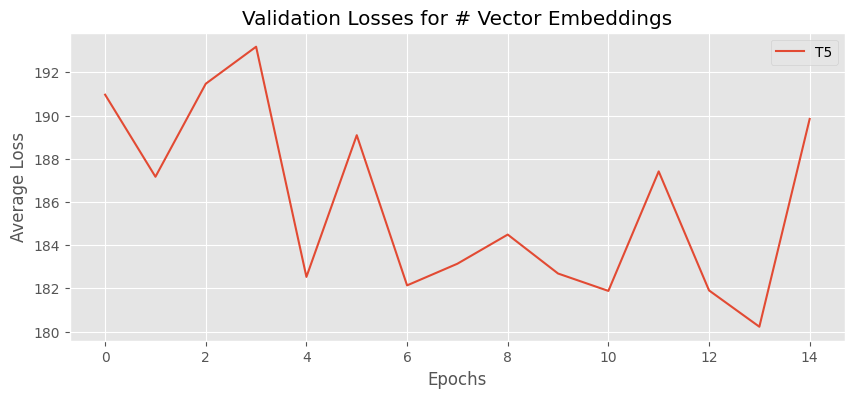

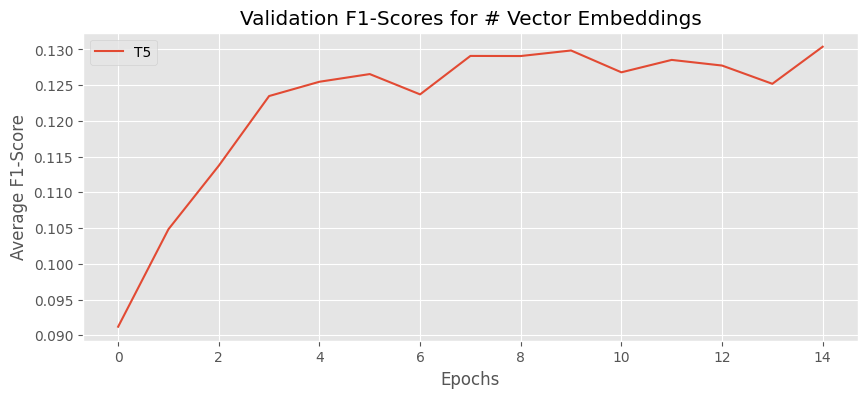

In [29]:
plt.figure(figsize = (10, 4))
# plt.plot(ems2_losses["val"], label = "EMS2")
plt.plot(t5_losses["val"], label = "T5")
# plt.plot(protbert_losses["val"], label = "ProtBERT")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
# plt.plot(ems2_scores["val"], label = "EMS2")
plt.plot(t5_scores["val"], label = "T5")
# plt.plot(protbert_scores["val"], label = "ProtBERT")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

# 9. Make Predictions

In [30]:
def predict(embeddings_source, final_labels_shape = 3000):
    
    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    if embeddings_source == "T5" or embeddings_source == "EMS2_t36":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "EMS2":
        model = ems2_model
        
    model.eval()
    
    labels = pd.read_csv(config.train_labels_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:final_labels_shape].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*final_labels_shape,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*final_labels_shape,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*final_labels_shape,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        confs_[i*final_labels_shape:(i+1)*final_labels_shape] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()[:final_labels_shape]
        ids_[i*final_labels_shape:(i+1)*final_labels_shape] = id[0]
        go_terms_[i*final_labels_shape:(i+1)*final_labels_shape] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [31]:
submission_df = predict(config.embedding_a_usar, final_labels_shape = config.num_labels)

Memory usage of dataframe is 2770.80 MB
Memory usage after optimization is: 692.70 MB
Decreased by 75.0%
GENERATE PREDICTION FOR TEST SET...


141865it [07:18, 323.79it/s]


PREDICTIONS DONE


In [32]:
submission_df.head(50)

,Id,GO term,Confidence
0,Q9CQV8,GO:0005575,0.873281
1,Q9CQV8,GO:0008150,0.879273
2,Q9CQV8,GO:0110165,0.870741
3,Q9CQV8,GO:0003674,0.878819
4,Q9CQV8,GO:0005622,0.847579
5,Q9CQV8,GO:0009987,0.835890
6,Q9CQV8,GO:0043226,0.825081
7,Q9CQV8,GO:0043229,0.793110
8,Q9CQV8,GO:0005488,0.878844
9,Q9CQV8,GO:0043227,0.816017


In [33]:
submission_df = submission_df[submission_df.Confidence >= 0.3]

In [34]:
len(submission_df)

27451317

In [35]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)